In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nilearn
import numpy as np
from nilearn import datasets, plotting
from sklearn.feature_selection import SelectPercentile, f_classif

In [4]:
cg_mean, cg_std = np.loadtxt('./results/beta_optimization').T
g_mean, g_std = np.loadtxt('./results/beta_optimization_gd.csv').T
l = 20
betas = np.linspace(0, 2, 50)
g_mean = g_mean[:l]
g_std = g_std[:l]
betas = betas[:l]

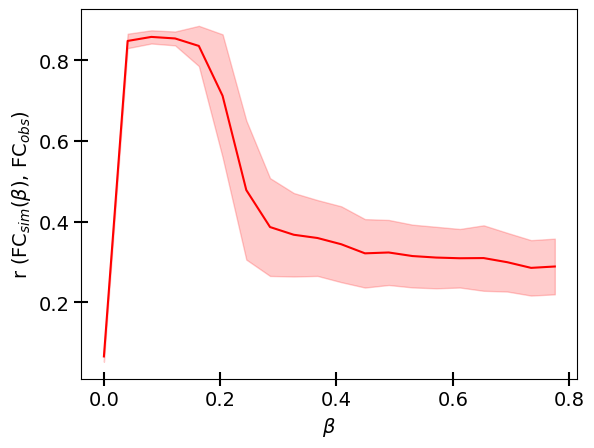

In [5]:
# plt.plot(betas, cg_mean, color='gray', label = 'Conjugate Gradient Descent')
# plt.fill_between(betas, cg_mean - cg_std, cg_mean + cg_std, color='gray', alpha=0.2)
plt.plot(betas, g_mean, color='red', label = 'Gradient Descent')
plt.fill_between(betas, g_mean - g_std, g_mean + g_std, color='red', alpha=0.2)
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'r (FC$_{sim}(\beta)$, FC$_{obs}$)', fontsize=14)
# plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

In [ ]:
betas

array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
       0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97959184,
       1.02040816, 1.06122449, 1.10204082, 1.14285714, 1.18367347,
       1.2244898 , 1.26530612, 1.30612245, 1.34693878, 1.3877551 ,
       1.42857143, 1.46938776, 1.51020408, 1.55102041, 1.59183673,
       1.63265306, 1.67346939, 1.71428571, 1.75510204, 1.79591837,
       1.83673469, 1.87755102, 1.91836735, 1.95918367, 2.        ])

In [ ]:
a = np.random.uniform(0, 1, size=(196, 0))

In [11]:
def top_pairs(scores, coordinates, n_rois = 116, k = 5):
    idx = np.argsort(scores)[-k:]
    rois = set() 
    pairs = set()
    rois_scores = {}
    for i in idx:
        r1 = i//n_rois
        r2 = i%n_rois
        rois.add(r1)
        rois.add(r2)
        pairs.add((r1, r2, scores[i]))
        rois_scores[r1] = scores[i]
        rois_scores[r2] = scores[i]

    rois = list(rois)
    coordinates = coordinates[rois]
    scores = scores.reshape(n_rois, n_rois)[rois][:, rois]
    return coordinates, scores, rois_scores, pairs

### Loading connectivity matrices 

In [12]:
ising_rep = np.load('../data/gd_all.npy')
fc_rep_ut = np.load('../data/sfc.npy')
fc_rep_mat = np.zeros((841, 116, 116))
fc_rep = np.zeros((841, 116*116))
for i in range(fc_rep_ut.shape[0]):
    fc_rep_mat[i][np.triu_indices(116)] = fc_rep_ut[i]
    fc_rep_mat[i] = np.triu(fc_rep_mat[i]) + np.tril(fc_rep_mat[i].T, k=-1)
    fc_rep[i] = fc_rep_mat[i].flatten()
print(ising_rep.shape, fc_rep.shape)
diag = np.load('../data/diag_all.npy')
fs = SelectPercentile(f_classif, percentile=10)


(841, 13456) (841, 13456)


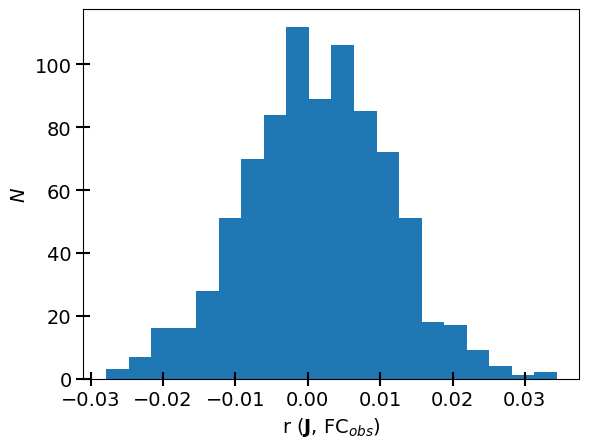

In [13]:
corrs = []
for idx in range(ising_rep.shape[0]):
    corrs.append(np.corrcoef(ising_rep[idx], fc_rep[idx])[0][1])
corrs = np.array(corrs)
plt.hist(corrs, bins=20)
plt.xlabel(r'r ($\mathbf{J}$, FC$_{obs}$)', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
# plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

In [14]:
corrs.shape

(841,)

In [8]:
aal = datasets.fetch_atlas_aal()

In [15]:
ising_rep = fs.fit_transform(ising_rep, diag)
ising_scores = fs.scores_
fc_rep = fs.fit_transform(fc_rep, diag)
fc_scores = fs.scores_

In [10]:
coordinates = plotting.find_parcellation_cut_coords(aal['maps'])

In [9]:
is_coords, is_scores, is_rois, is_pairs = top_pairs(ising_scores, coordinates, k=5)
plotting.plot_connectome(is_scores, is_coords)

NameError: name 'top_pairs' is not defined

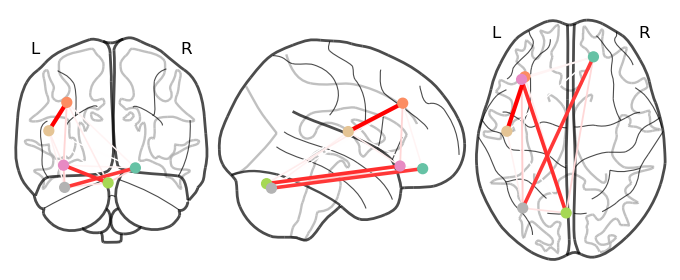

In [18]:
fc_coords, f_scores, fc_rois, fc_pairs = top_pairs(fc_scores, coordinates, k=5)
plotting.plot_connectome(f_scores, fc_coords)

In [19]:
labels = [(aal.labels[i], aal.labels[j], sc) for i, j, sc in fc_pairs]
labels

[('Frontal_Inf_Orb_L', 'Vermis_7', 37.98146452010402),
 ('Rolandic_Oper_L', 'Frontal_Mid_L', 46.401333426722246),
 ('Vermis_7', 'Frontal_Inf_Orb_L', 37.98146452010402),
 ('Frontal_Mid_L', 'Rolandic_Oper_L', 46.401333426722246),
 ('Frontal_Sup_Orb_R', 'Cerebelum_Crus1_L', 36.07735545427141)]

In [20]:
labels = [(aal.labels[i], aal.labels[j], sc) for i, j, sc in is_pairs]
labels

[('Postcentral_L', 'Lingual_L', 16.294879978747908),
 ('Parietal_Inf_L', 'Paracentral_Lobule_L', 16.208868866706624),
 ('Occipital_Mid_R', 'Calcarine_L', 16.39882224049977),
 ('Vermis_3', 'Cuneus_R', 16.01626255510945),
 ('Calcarine_L', 'Occipital_Mid_R', 17.941764124924827)]

## ROI Distances

In [2]:
fc_rep_ut = np.load('../data/AAL_reps/sfc_NYU.npy')
fc_rep_mat = np.zeros((fc_rep_ut.shape[0], 116, 116))
fc_rep = np.zeros((fc_rep_ut.shape[0], 116*116))
for i in range(fc_rep_ut.shape[0]):
    fc_rep_mat[i][np.triu_indices(116)] = fc_rep_ut[i]
    fc_rep_mat[i] = np.triu(fc_rep_mat[i]) + np.tril(fc_rep_mat[i].T, k=-1)
    fc_rep[i] = fc_rep_mat[i].flatten()

In [3]:
ising_rep_mat = np.load('../data/AAL_reps/ising_NYU.npy')

In [4]:
diag = np.load('../data/AAL_reps/diag_NYU.npy')

In [10]:
from scipy.spatial.distance import cdist

coordinates = plotting.find_parcellation_cut_coords(aal['maps'])
roi_dists = cdist(coordinates, coordinates)
neg_diag_idxs = np.where(diag == 0)[0]
pos_diag_idxs = np.where(diag == 1)[0]

In [11]:
neg_diag_fc_rep = np.mean(fc_rep_mat[neg_diag_idxs], axis=0)
pos_diag_fc_rep = np.mean(fc_rep_mat[pos_diag_idxs], axis=0)
neg_diag_ising_rep = np.mean(ising_rep_mat[neg_diag_idxs], axis=0)
pos_diag_ising_rep = np.mean(ising_rep_mat[pos_diag_idxs], axis=0)
all_fc_rep = np.mean(fc_rep_mat, axis=0)
all_ising_rep = np.mean(ising_rep_mat, axis=0)

In [12]:
def get_dist_fc_ising (fc_rep, ising_rep, roi_dists):
    x_dists, y_fc, y_ising = [], [], []
    for i in range(len(fc_rep)):
        for j in range(i+1, len(fc_rep)):
            x_dists.append(roi_dists[i][j])
            y_fc.append(fc_rep[i][j])
            y_ising.append(ising_rep[i][j])
            # print(f"y_fc: {fc_rep[i][j]}, y_ising: {ising_rep}")
    y_fc = np.array(y_fc)
    y_fc[np.isnan(y_fc)] = 0
    return np.array(x_dists), np.array(y_fc), np.array(y_ising)

neg_x_dists, neg_y_fc, neg_y_ising = get_dist_fc_ising(neg_diag_fc_rep, neg_diag_ising_rep, roi_dists)
pos_x_dists, pos_y_fc, pos_y_ising = get_dist_fc_ising(pos_diag_fc_rep, pos_diag_ising_rep, roi_dists)
all_x_dists, all_y_fc, all_y_ising = get_dist_fc_ising(all_fc_rep, all_ising_rep, roi_dists)

Text(0.5, 1.0, 'FC vs ROI Distance')

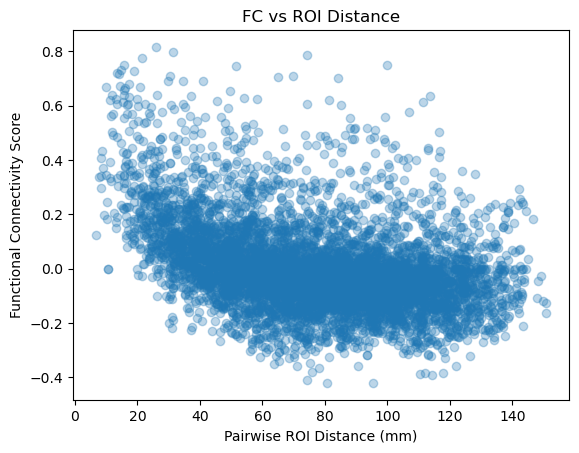

In [13]:

plt.scatter(all_x_dists, all_y_fc, alpha=0.3)
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Functional Connectivity Score")
plt.title("FC vs ROI Distance")

Text(0.5, 1.0, 'Ising Pairwise Connection vs ROI Distance for ASD-allative Group')

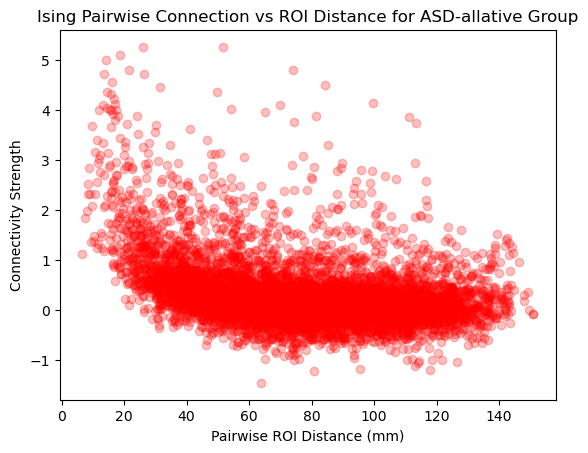

In [14]:
plt.scatter(all_x_dists, all_y_ising, alpha=0.25, color='red')
# plt.plot(all_x_dists[all_y_ising > 1], np.mean(all_y_ising[all_y_ising > 1]))
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Connectivity Strength")
plt.title("Ising Pairwise Connection vs ROI Distance for ASD-allative Group")

In [15]:
def binned_mean(x, y, n_bins = 10):
    y = (y - np.mean(y))/np.std(y)
    x_binned = np.linspace(0, max(x), n_bins)
    data = []
    binz = {i: [] for i in range(len(x_binned))}
    for idx, i in enumerate(y):
        j = 0
        for v in x_binned: 
            if x[idx] <= v:
                break
            j+=1
        binz[j].append(y[idx])
    conn_mean = np.array([np.mean(i) for i in binz.values()])
    conn_std = np.array([np.std(i) for i in binz.values()]) 
    return x_binned, conn_mean, conn_std

In [16]:
x, fc_mean, fc_std = binned_mean(all_x_dists, all_y_fc)
x, ising_mean, ising_std = binned_mean(all_x_dists, all_y_ising)

/home/shivansh/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shivansh/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shivansh/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/shivansh/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/shivansh/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


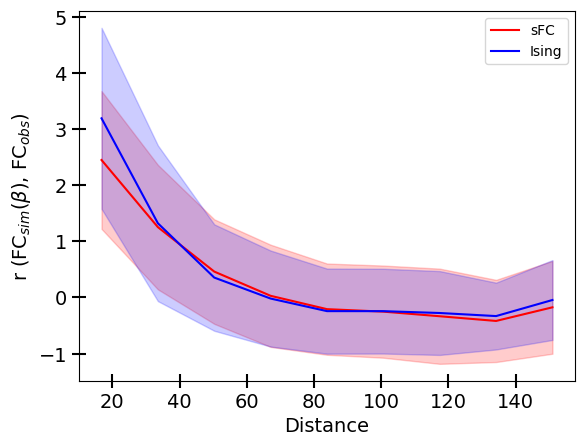

In [17]:
plt.plot(x, fc_mean, color='red', label = 'sFC')
plt.fill_between(x, fc_mean - fc_std, fc_mean + fc_std, color='red', alpha=0.2)
plt.plot(x, ising_mean, color='blue', label = 'Ising')
plt.fill_between(x, ising_mean - ising_std, ising_mean + ising_std, color='blue', alpha=0.2)
plt.xlabel(r'Distance', fontsize=14)
plt.ylabel(r'r (FC$_{sim}(\beta)$, FC$_{obs}$)', fontsize=14)
plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

array([        nan,  0.38439539,  0.19693873,  0.07285193,  0.00522127,
       -0.0320483 , -0.03897089, -0.05182971, -0.06495436, -0.02689531])